In [2]:
# The code is based on Kera's tutorial on semi-supervised image classification: https://keras.io/examples/vision/semisupervised_simclr/

In [3]:
import os
import gc
import random
import time
from pathlib import Path
import math

import matplotlib.pyplot as plt
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Dataset hyperparameters
image_size = 150
image_channels = 3

# Algorithm hyperparameters
num_epochs = 10
width = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [7]:
# Dataset parameters 
unlabeled_dataset_size = 53317 
labeled_dataset_size = math.floor(unlabeled_dataset_size * 0.05)
print(
    f"batch size is {unlabeled_dataset_size} (unlabeled) + {labeled_dataset_size} (labeled)"
)

batch size is 53317 (unlabeled) + 2665 (labeled)


In [8]:
steps_per_epoch = 100
unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
labeled_batch_size = labeled_dataset_size // steps_per_epoch
print(
    f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
)

batch size is 533 (unlabeled) + 26 (labeled)


In [9]:
# base_dir = os.path.join('/content/drive/My Drive/fourthbrain/Capstone/OCT2017/')
resized_dir = os.path.join('/content/drive/My Drive/fourthbrain/Capstone/OCT2017_Resized/')

In [10]:
from keras.preprocessing.image import ImageDataGenerator

def load_images(base_dir, data_type, batch_size, shuffle=True):
    data_path = os.path.join(base_dir, data_type + '/')
    data_gen = ImageDataGenerator(rescale=1. / 255)
    return data_gen.flow_from_directory(data_path, target_size=(image_size, image_size), class_mode='sparse', batch_size=batch_size, shuffle=shuffle)

In [11]:
train_dataset = load_images(resized_dir, 'train', unlabeled_batch_size)

Found 53317 images belonging to 4 classes.


In [12]:
test_dataset = load_images(resized_dir, 'test', unlabeled_batch_size, shuffle=False)

Found 968 images belonging to 4 classes.


In [ ]:
# val_dataset = load_images(resized_dir, 'val', batch_size)

In [13]:
# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            # layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )

In [14]:
sample_imgs =  next(train_dataset)

In [15]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = sample_imgs[0][:num_images] 
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()

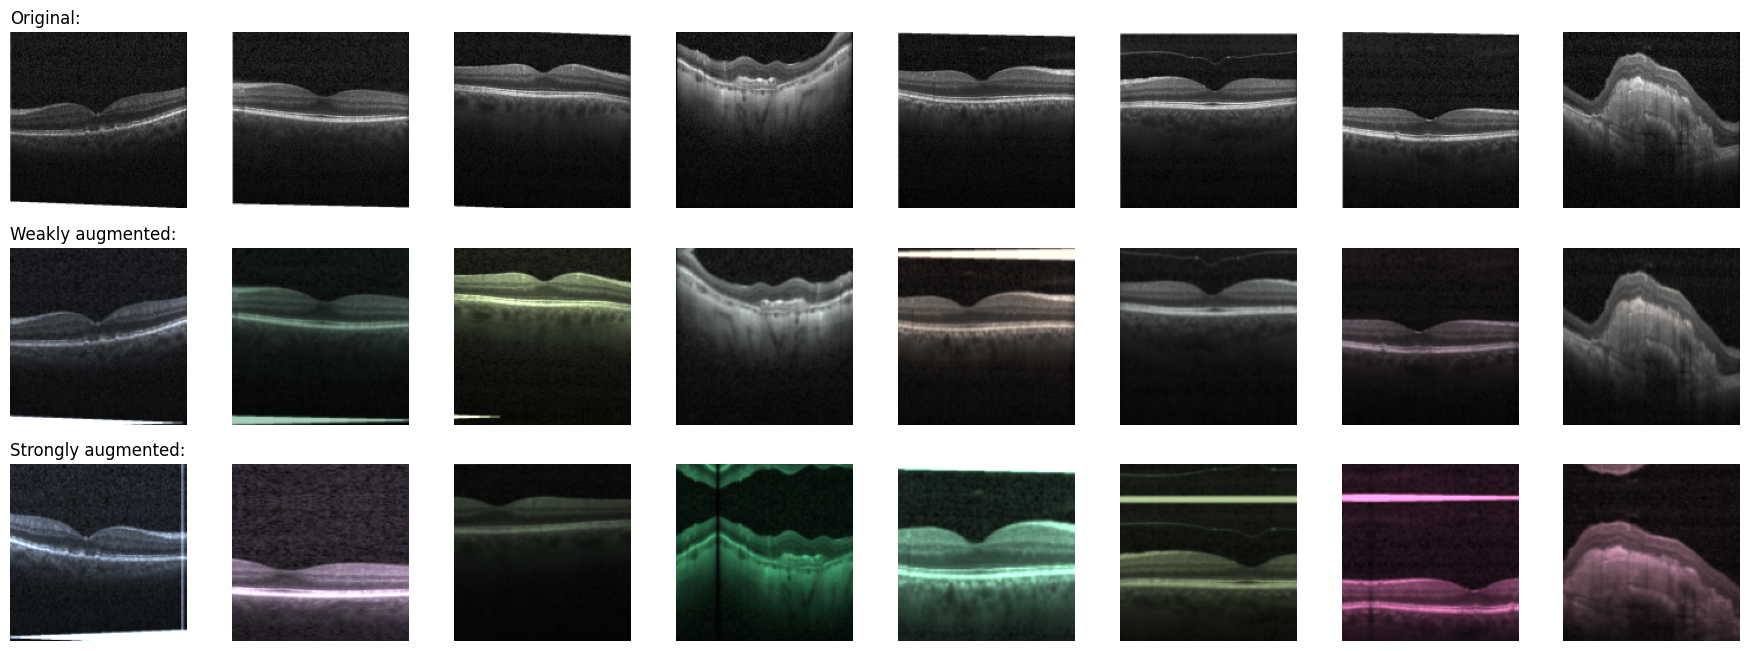

In [16]:
visualize_augmentations(num_images=8)

In [17]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )

In [18]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(10)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        #(unlabeled_images, _), (labeled_images, labels) = data
        # Both labeled and unlabeled images are used, without labels
        # images = tf.concat((unlabeled_images, labeled_images), axis=0)

        images, labels = data
        labeled_images = images[-labeled_dataset_size:]
        
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}

In [ ]:
# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 74, 74, 128)       3584      
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 36, 128)       147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       147584    
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1048704   
                                                                 
Total params: 1,495,040
Trainable params: 1,495,040
Non-tra

In [ ]:
labeled_train_dataset = load_images(resized_dir, 'train_labeled', unlabeled_batch_size)

Found 2664 images belonging to 4 classes.


In [1]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(10),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, epochs=num_epochs, validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

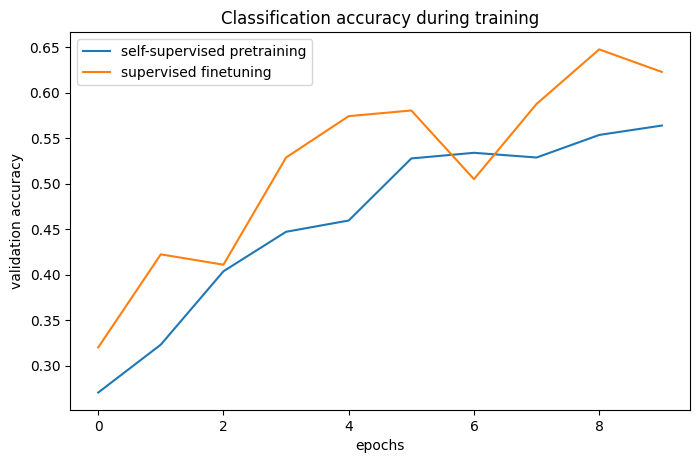

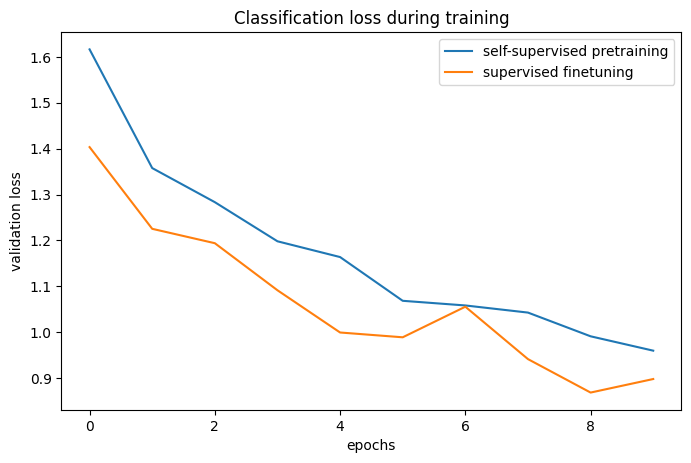

In [ ]:
def plot_training_curves(pretraining_history, finetuning_history): 
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history) 

In [ ]:
predictions = finetuning_model.predict(test_dataset)
print(predictions.shape)

predicted_classes = np.argmax(predictions, axis = 1)

(968, 10)


In [ ]:
print(predicted_classes)

[0 2 0 0 1 2 0 0 1 0 0 2 0 2 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 1 0 0 1 0 2 2 1 0 0 0 0 0 1 1 1 1
 1 1 1 0 2 1 1 2 0 1 0 1 2 1 1 0 2 0 0 2 0 0 0 0 1 0 0 2 0 1 0 0 1 0 0 1 0
 1 0 0 0 2 0 0 2 2 0 1 2 0 2 2 0 1 2 0 2 1 0 2 0 0 0 1 1 0 0 0 1 1 0 0 0 2
 0 0 0 0 0 2 0 0 0 2 1 0 1 2 1 0 0 1 2 0 2 0 0 0 2 0 0 0 1 2 0 0 0 0 0 0 0
 0 0 2 0 1 0 2 1 1 0 0 1 0 0 0 0 0 2 0 1 0 0 0 0 2 2 1 2 1 1 1 2 2 2 0 0 1
 0 0 0 0 0 2 1 0 0 0 1 0 0 0 0 0 1 0 0 0 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 3
 1 3 2 2 1 1 1 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 1 1 2 1 3 1 1 1 1 2 2 2
 2 3 1 1 2 1 1 1 2 1 2 2 1 1 1 2 1 2 3 2 2 1 1 2 2 1 1 1 2 1 2 2 1 1 2 1 2
 1 1 2 3 2 2 3 2 1 1 1 2 1 1 3 2 2 2 2 0 1 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 1
 2 1 3 1 1 1 1 2 1 2 0 2 2 1 2 3 2 2 2 2 1 2 2 1 1 1 2 1 1 1 1 1 1 2 1 2 2
 2 2 1 1 1 2 1 2 3 3 3 1 1 1 2 3 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 1 1 2 1 3 2 2 1 2 1 1 2 2 2 1 1 1 1 2 2 1 1 2 1 2 1 2 1 1 1 1 2 2 2 1 2
 2 1 1 2 2 2 2 2 2 2 2 2 

In [ ]:
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

In [ ]:
import sklearn.metrics

In [ ]:
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.96      0.60      0.74       242
         DME       0.59      0.46      0.52       242
      DRUSEN       0.44      0.84      0.58       242
      NORMAL       0.84      0.59      0.69       242

    accuracy                           0.62       968
   macro avg       0.71      0.62      0.63       968
weighted avg       0.71      0.62      0.63       968

